# Imports

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random 
from scipy import stats
from ydata_profiling          import ProfileReport

from sklearn.preprocessing    import MinMaxScaler,RobustScaler
from sklearn.model_selection  import train_test_split, StratifiedKFold,RandomizedSearchCV
from sklearn.model_selection  import cross_val_score, cross_validate

from sklearn.ensemble         import RandomForestClassifier
from sklearn.linear_model     import LogisticRegression,SGDClassifier
from xgboost                  import XGBClassifier
from sklearn.neighbors        import KNeighborsClassifier
from lightgbm                 import LGBMClassifier

from sklearn.metrics          import classification_report, cohen_kappa_score, roc_curve, brier_score_loss,roc_auc_score
from sklearn.metrics          import accuracy_score, precision_score,recall_score,confusion_matrix,f1_score

from sklearn.calibration      import CalibratedClassifierCV
from sklearn.calibration      import calibration_curve

In [219]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

# Helper Functions

In [3]:
def ml_metrics( model_name, y_true, yhat):
    accuracy = accuracy_score(y_true, yhat)
    precision = precision_score(y_true, yhat)
    recall = recall_score(y_true, yhat)

    return pd.DataFrame({'Model Name': model_name, 
                        'ACC': accuracy,
                        'PRECISION': precision,
                        'RECALL': recall}, index = [0])

In [173]:
def model_cross_validation(model_name, model, X, y, threshold):
    skf = StratifiedKFold(n_splits=10)
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    kappa_list = []
    auc_score_list = []

    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold, y_train_fold.values.ravel())
        
        probs = pd.DataFrame(model.predict_proba(x_test_fold)[:, 1], columns=['prob'])
        
        # applies the threshold
        y_hat = probs['prob'].apply(lambda x: 1 if x > threshold else 0)
        
        precision = precision_score(y_test_fold, y_hat)
        recall = recall_score(y_test_fold, y_hat)
        f1 = f1_score(y_test_fold, y_hat)
        accuracy = accuracy_score(y_test_fold, y_hat)
        kappa = cohen_kappa_score(y_test_fold, y_hat)
        auc_score = roc_auc_score(y_test_fold, probs)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        kappa_list.append(kappa)
        auc_score_list.append(auc_score)


    result = {'Model Name': model_name, 
                'Precision': round(100*np.mean(precision_list),2),
                'Recall': round(100*np.mean(recall_list),2),
                'F1-Score': round(100*np.mean(f1_list),2),
                'Accuracy': round(100*np.mean(accuracy_list),2),
                'Kappa': round(100*np.mean(kappa_list),2),
                'AUC': round(100*np.mean(auc_score_list),2)}
    return pd.DataFrame(result, index = [0])

In [69]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

# Load Data

In [5]:
path = '../data/raw/'

In [6]:
df = pd.read_csv(path + 'cardio_train.csv',sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
# gender => 1:female, 2:male

# Data Description

## Rename columns

In [8]:
df.rename(columns = {'ap_hi':'systolic','ap_lo':'diastolic','alco':'alcohol'}, inplace = True)

## Data dimension

In [9]:
print('Quantity of rows and columns: {}'.format(df.shape))

Quantity of rows and columns: (70000, 13)


## Data types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   systolic     70000 non-null  int64  
 6   diastolic    70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alcohol      70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## Check NA

In [11]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
systolic       0
diastolic      0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
cardio         0
dtype: int64

## Replace NA

In [12]:
# None

## Change dtypes

In [13]:
# None

## Descriptive Statistics

In [14]:
df1 = df.copy()

### Numerical Attributes

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [16]:
# central tendency
ct_mean = pd.DataFrame( num_attributes.apply( np.mean )).T
ct_median = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion

ct_std = pd.DataFrame( num_attributes.apply( np.std )).T
ct_min = pd.DataFrame( num_attributes.apply( np.min )).T
ct_max = pd.DataFrame( num_attributes.apply( np.max )).T
ct_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
ct_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
ct_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

In [17]:
num_analysis = pd.concat([ct_mean, ct_median, ct_std, ct_min, 
                          ct_max, ct_range, ct_skew, ct_kurtosis]).T.reset_index()
num_analysis.columns = ['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_analysis

# kurtosis > 0 -> it is more "narrowed" the distribution
# skew > 0 -> the distribution tend to be more on the right side (values above the 'mean')

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,id,49972.420,50001.5,28851.096,0.0,99999.0,99999.0,-0.001,-1.198
1,age,19468.866,19703.0,2467.234,10798.0,23713.0,12915.0,-0.307,-0.823
2,gender,1.350,1.0,0.477,1.0,2.0,1.0,0.631,-1.602
3,height,164.359,165.0,8.210,55.0,250.0,195.0,-0.642,7.944
4,weight,74.206,72.0,14.396,10.0,200.0,190.0,1.012,2.587
5,systolic,128.817,120.0,154.010,-150.0,16020.0,16170.0,85.296,7580.075
6,diastolic,96.630,80.0,188.471,-70.0,11000.0,11070.0,32.114,1425.915
7,cholesterol,1.367,1.0,0.680,1.0,3.0,2.0,1.587,0.994
8,gluc,1.226,1.0,0.572,1.0,3.0,2.0,2.397,4.294
9,smoke,0.088,0.0,0.283,0.0,1.0,1.0,2.906,6.444


# Data Filtering

In [18]:
df2 = df1.copy()
df2.shape

(70000, 13)

In [19]:
for i in ['cholesterol', 'gluc', 'smoke', 'alcohol', 'active']:
    print(i,'\n',df2[i].value_counts(normalize = True)*100)

cholesterol 
 1    74.836
2    13.641
3    11.523
Name: cholesterol, dtype: float64
gluc 
 1    84.970
3     7.616
2     7.414
Name: gluc, dtype: float64
smoke 
 0    91.187
1     8.813
Name: smoke, dtype: float64
alcohol 
 0    94.623
1     5.377
Name: alcohol, dtype: float64
active 
 1    80.373
0    19.627
Name: active, dtype: float64


## incorrect weight

In [20]:
df2.loc[df2['gender'] == 1].sort_values(by='weight').head(10)

,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio
60188,85931,21855,1,162,21.0,120,80,2,1,0,0,1,1
26806,38312,23284,1,157,23.0,110,80,1,1,0,0,1,0
60699,86650,18875,1,171,29.0,110,70,2,1,0,0,1,1
3752,5306,15400,1,120,30.0,110,70,1,1,0,0,1,0
18559,26503,18140,1,160,30.0,120,80,1,1,0,0,1,1
41905,59853,21334,1,143,30.0,103,61,2,1,0,0,1,0
38417,54851,21809,1,154,32.0,110,60,1,1,0,0,1,0
35314,50443,19802,1,146,32.0,130,80,1,2,0,0,0,0
22016,31439,15359,1,146,32.0,100,70,1,1,0,0,0,0
65082,92896,22688,1,145,33.0,130,1000,2,1,0,0,1,1


In [21]:
df2.loc[(df2['gender'] == 1) & (df2['weight'] < 45)].shape

(282, 13)

In [22]:
df2.loc[(df2['weight'] < 45)].shape

(302, 13)

In [23]:
df2 = df2.loc[(df2['weight'] >= 40)].copy()

## incorrect height

In [24]:
df2.loc[(df2['height'] < 120)].shape

(52, 13)

In [25]:
df2 = df2.loc[~((df2['height'] <= 110) | (df2['height'] >= 210))].copy()

## Incorrect Blood Pressure

In [26]:
# removes outliers: blood pressure
df2 = df2[~((df2['systolic'] >= 210) | (df2['diastolic'] >= 150) 
           | (df2['systolic'] <= 90) | (df2['diastolic'] <= 65))]

In [27]:
df2.to_parquet('../data/raw/cardio_without_outliers.parquet',index = False)

# Feature Engineering

In [28]:
df3 = df2.copy()
df3.shape

(65442, 13)

In [29]:
df3 = pd.read_parquet('../data/raw/cardio_without_outliers.parquet')

##### BMI

As mentioned in [this source](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html), we can categorize people according with their BMI.

| BMI             | Weight Status           |
|-----------------|-------------------------|
| Below 18\.5     | Underweight             |
| 18\.5 \- 24\.9  | Normal or Health weight |
| 25\.0 \- 29\.9  | Overweight              |
| 30\.0 and above | Obese                   |

In [30]:
df3['bmi'] = df3['weight'] / ((df3['height'] * df3['height']) / 10000 )
df3['bmi'].unique()

array([21.96712018, 34.92767916, 23.50780533, ..., 19.23018223,
       29.19412649, 50.47268066])

In [31]:
# calculates the weight status
df3['weight_s'] = df3['bmi'].apply(lambda x: 'underweight' if x < 18.5 
                                             else 'normal' if (x >= 18.5) & (x <= 29.4)
                                             else 'overweight' if (x >= 25) & (x <= 29.9)
                                             else 'obese')

In [32]:
# calculates the blood pressures
df3['blood_pressure_s'] = ['low' if (ap_hi <= 90) & (ap_lo <= 60)
                            else 'normal' if ((ap_hi > 90) & (ap_hi < 120)) & ((ap_lo > 60) & (ap_lo < 80))
                            else 'elevated' if ((ap_hi >= 120) & (ap_hi <= 120)) & (ap_lo < 80)
                            else 'high stage one' if ((ap_hi >= 130) & (ap_hi <= 139)) | ((ap_lo >= 80) & (ap_lo <=89))
                            else 'high stage two' if (ap_hi >= 140) | (ap_lo >= 90)
                            else 'hypertensive crisis'
                            for ap_hi, ap_lo in zip(df3['systolic'], df3['diastolic'])]

In [33]:
# age in years
df3['age_y'] = df['age']/365
df3['age_y'] = df3['age_y'].astype('int64')

# gender
gender_map = {1:'female',2:'male'}
df3['gender_s'] = df3['gender'].map(gender_map)

# cholesterol
cholesterol_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
df3['cholesterol_s'] = df3['cholesterol'].map(cholesterol_map)

# glucose
gluc_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
df3['gluc_s'] = df3['gluc'].map(gluc_map)

# smoking
smoke_map = {1: 'smoking', 0: 'non-smoking'}
df3['smoke_s'] = df3['smoke'].map(smoke_map)

# alcohol
alcohol_map = {1: 'alcoolic', 0: 'non alcoolic'}
df3['alcohol_s'] = df3['alcohol'].map(alcohol_map)

# active
active_map = {1: 'active', 0: 'non active'}
df3['active_s'] = df3['active'].map(active_map)

df3.head()

,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,bmi,weight_s,blood_pressure_s,age_y,gender_s,cholesterol_s,gluc_s,smoke_s,alcohol_s,active_s
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967,normal,high stage one,50,male,normal,normal,non-smoking,non alcoolic,active
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.928,obese,high stage two,55,female,well above normal,normal,non-smoking,non alcoolic,active
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.508,normal,high stage one,51,female,well above normal,normal,non-smoking,non alcoolic,non active
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710,normal,high stage two,48,male,normal,normal,non-smoking,non alcoolic,active
4,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.385,normal,high stage one,47,female,above normal,above normal,non-smoking,non alcoolic,non active


In [35]:
df3.to_parquet('../data/raw/cardio_feature_engineering.parquet',index = False)

# Exploratory Data Analysis

In [27]:
df4 = df3.copy()
df4.shape

(69646, 20)

In [36]:
df4 = pd.read_parquet('../data/raw/cardio_feature_engineering.parquet')

In [28]:
# profile = ProfileReport( df3 )
# profile.to_file('output_v1.html')

In [37]:
df4.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alcohol', 'active', 'cardio', 'bmi',
       'weight_s', 'blood_pressure_s', 'age_y', 'gender_s', 'cholesterol_s',
       'gluc_s', 'smoke_s', 'alcohol_s', 'active_s'],
      dtype='object')

## Univariate analysis

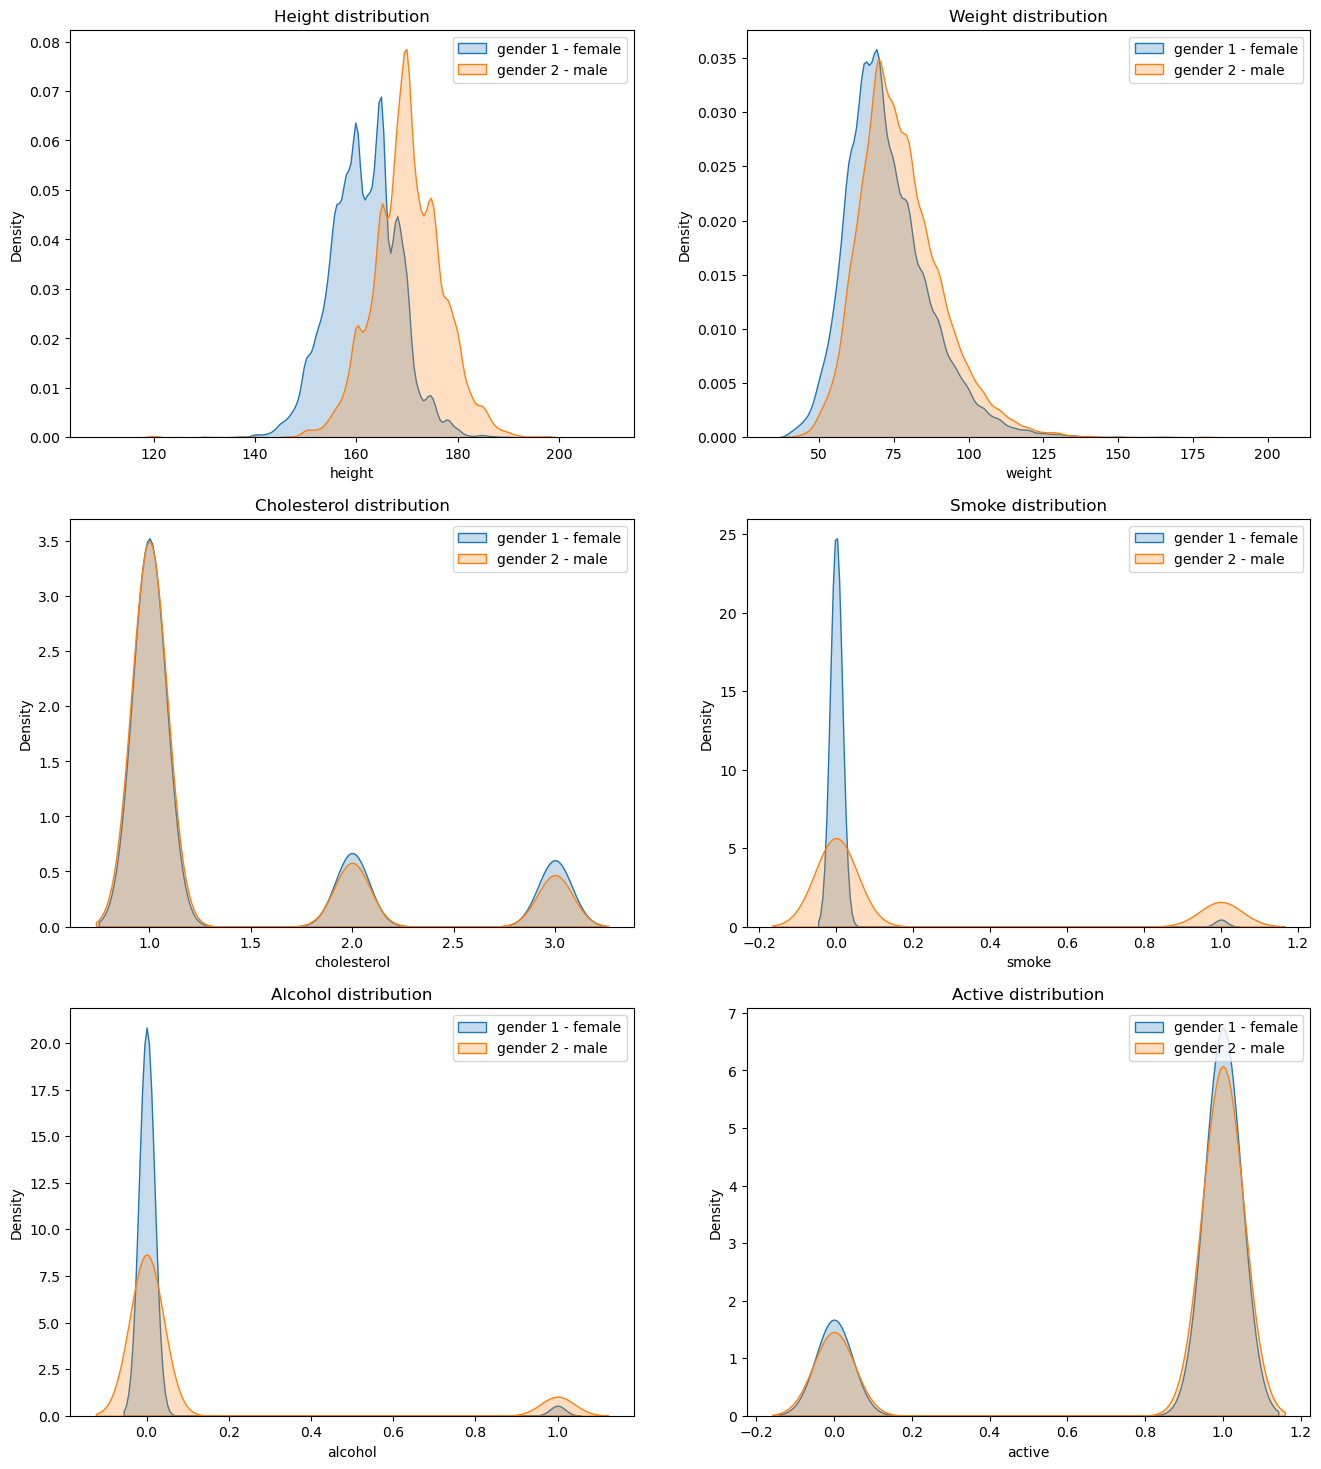

In [40]:
fig, axes = plt.subplots(3,2,figsize=(16,18))

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['height'], fill = True, label = 'gender 1 - female', 
            ax = axes[0,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['height'], fill = True, label = 'gender 2 - male', 
            ax = axes[0,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['weight'], fill = True, label = 'gender 1 - female', 
            ax = axes[0,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['weight'], fill = True, label = 'gender 2 - male', 
            ax = axes[0,1], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['cholesterol'], fill = True, label = 'gender 1 - female', 
            ax = axes[1,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['cholesterol'], fill = True, label = 'gender 2 - male', 
            ax = axes[1,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['smoke'], fill = True, label = 'gender 1 - female', 
            ax = axes[1,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['smoke'], fill = True, label = 'gender 2 - male', 
            ax = axes[1,1], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['alcohol'], fill = True, label = 'gender 1 - female', 
            ax = axes[2,0], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['alcohol'], fill = True, label = 'gender 2 - male', 
            ax = axes[2,0], legend = True);

sns.kdeplot(df4.loc[df4['gender_s'] == 'female']['active'], fill = True, label = 'gender 1 - female', 
            ax = axes[2,1], legend = True);
sns.kdeplot(df4.loc[df4['gender_s'] == 'male']['active'], fill = True, label = 'gender 2 - male', 
            ax = axes[2,1], legend = True);


axes[0,0].set_title('Height distribution')
axes[0,1].set_title('Weight distribution')
axes[1,0].set_title('Cholesterol distribution')
axes[1,1].set_title('Smoke distribution')
axes[2,0].set_title('Alcohol distribution')
axes[2,1].set_title('Active distribution')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,0].legend()
axes[2,1].legend()

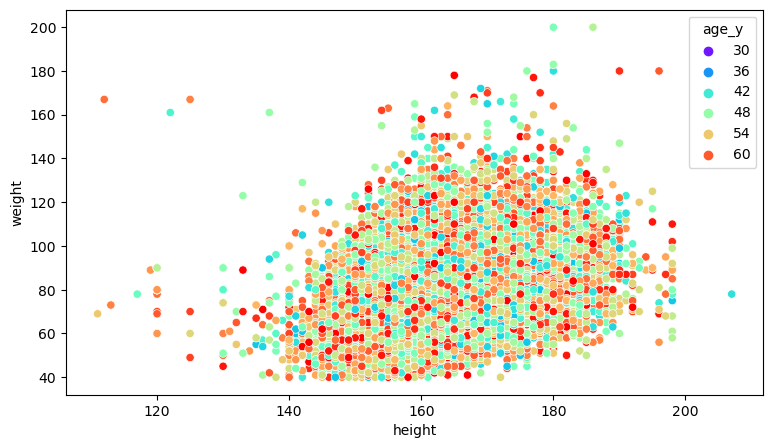

In [41]:
fig, axes = plt.subplots(1,1,figsize = (9,5))
sns.scatterplot(data = df4,x = 'height',y = 'weight', hue = 'age_y', palette = 'rainbow',ax = axes);

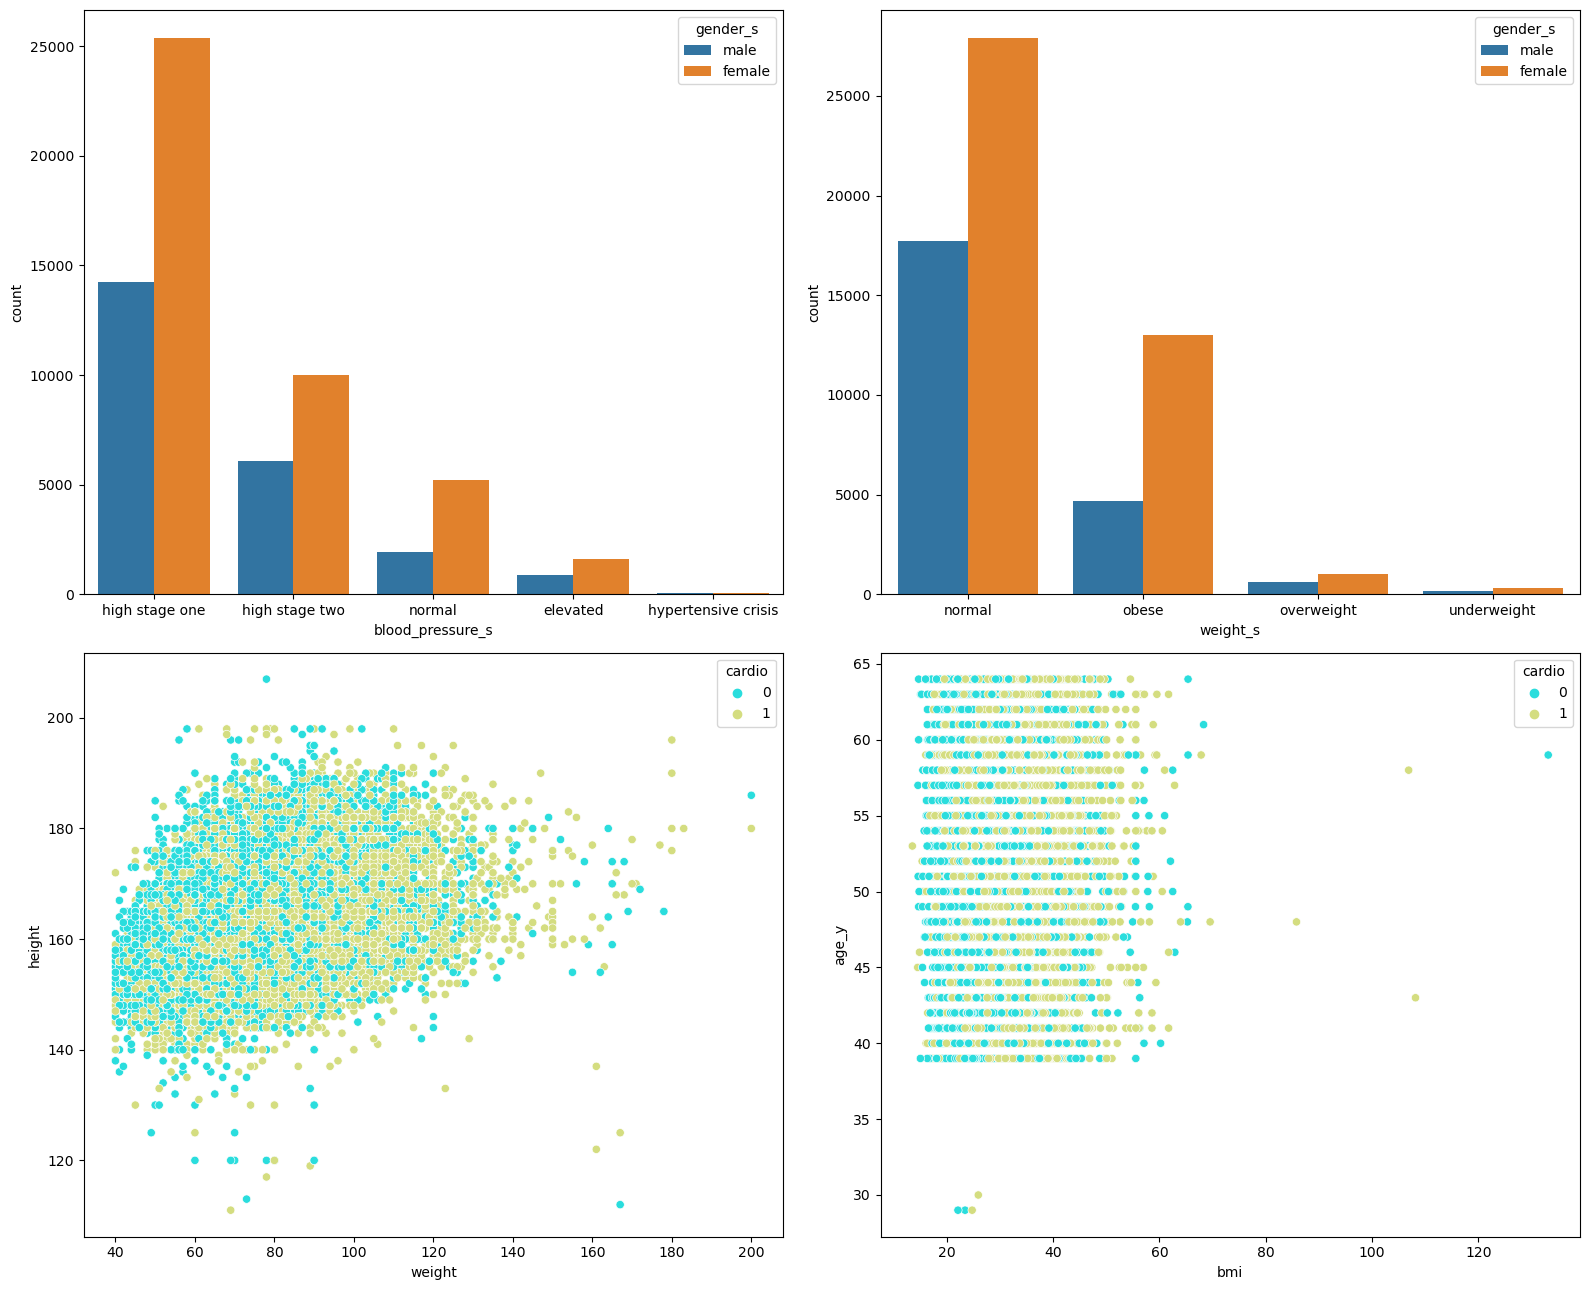

In [48]:
fig, axes = plt.subplots(2,2,figsize = (16,13))

sns.countplot(data = df4, x = 'blood_pressure_s',hue = 'gender_s', ax = axes[0,0]);

sns.countplot(data = df4, x = 'weight_s',hue = 'gender_s', ax = axes[0,1]);

sns.scatterplot(data = df4,x = 'weight',y = 'height', hue = 'cardio', palette = 'rainbow',ax = axes[1,0]);

sns.scatterplot(data = df4,x = 'bmi',y = 'age_y', hue = 'cardio', palette = 'rainbow',ax = axes[1,1]);

plt.tight_layout();

## Bivariate analysis

- H1 - we have more cardio disease in male individuals then female
- H2 - we have more cardio diseases in individuals with age higher than the average
- H3 - In proportion, individuals with cholesterol 2 have more cardio disease than 1
- H4 - In proportion, individuals with cholesterol 3 have more cardio disease than 2
- H5 - In proportion, individuals with alcohol 1 have more cardio disease than 0
- H6 - In proportion, individuals with smoke 1 have more cardio disease than 0
- H7 - In proportion, individuals with active 1 have less cardio disease than 0
- H8 - In proportion, individuals with glucose 2 have more cardio disease than 1
- H9 - In proportion, individuals with glucose 3 have more cardio disease than 2

### - H1 - we have more cardio disease in male individuals then female


In [49]:
aux1 = df4.groupby(['gender_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,gender_s,cardio,qtde_cardio
0,female,0,20854
1,female,1,21421
2,male,0,11441
3,male,1,11726


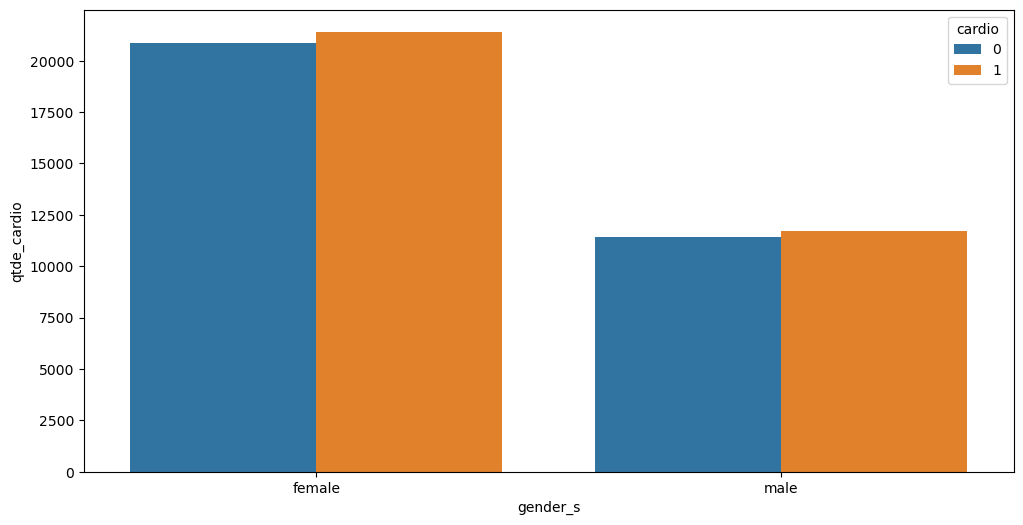

In [50]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'gender_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - We have a proportion of female above than male, but male has more diseases than female

### - H2 - we have more cardio diseases in individuals with age higher than the average


In [51]:
avg_age = df4['age_y'].mean()
aux1 = df4.copy()
aux1['rel_avg_age'] = 'below average'
aux1.loc[aux1['age_y'] >= avg_age, 'rel_avg_age'] = 'above average'
aux1 = aux1.groupby(['rel_avg_age','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,rel_avg_age,cardio,qtde_cardio
0,above average,0,17913
1,above average,1,18284
2,below average,0,14382
3,below average,1,14863


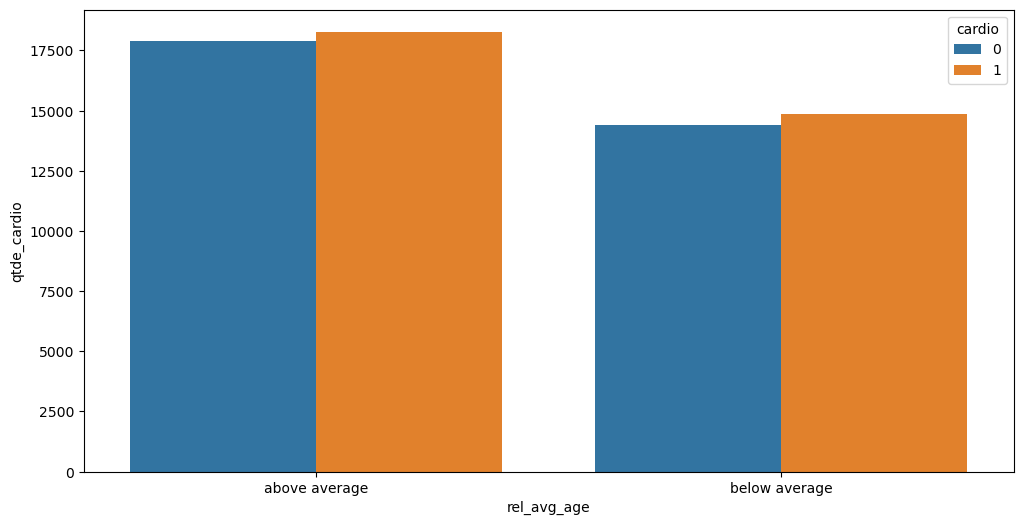

In [52]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'rel_avg_age',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - individuals with age above the average has more chances of cardio disease

### - H3 - In proportion, individuals with cholesterol 2 have more cardio disease than 1


In [53]:
aux1 = df4.groupby(['cholesterol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1 = aux1.loc[aux1['cholesterol_s'].isin(['normal','above normal'])]
aux1.head()

,cholesterol_s,cardio,qtde_cardio
0,above normal,0,3453
1,above normal,1,5395
2,normal,0,27044
3,normal,1,21850


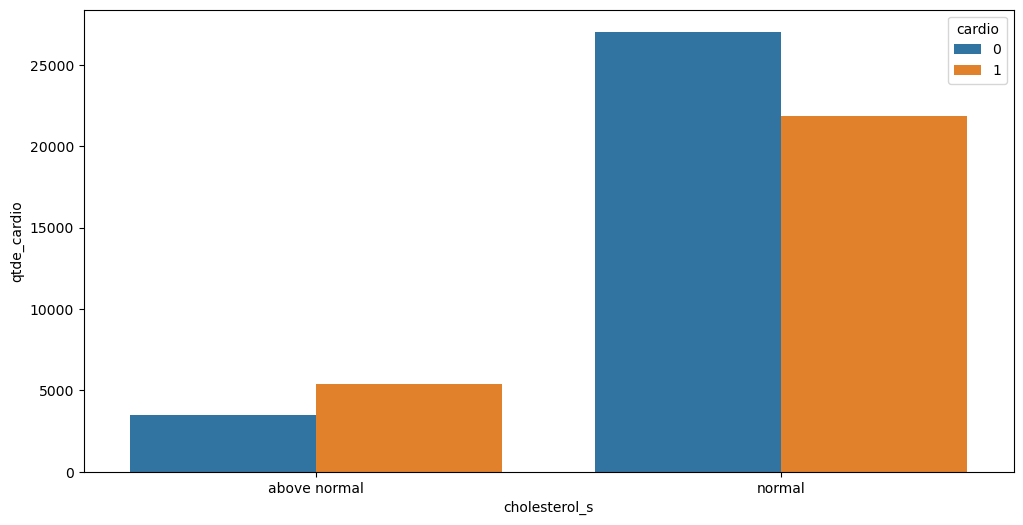

In [54]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'cholesterol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE

### - H4 - In proportion, individuals with cholesterol 3 have more cardio disease than 2


In [55]:
aux1 = df4.groupby(['cholesterol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1 = aux1.loc[aux1['cholesterol_s'].isin(['well above normal','above normal'])]
aux1.head()

,cholesterol_s,cardio,qtde_cardio
0,above normal,0,3453
1,above normal,1,5395
4,well above normal,0,1798
5,well above normal,1,5902


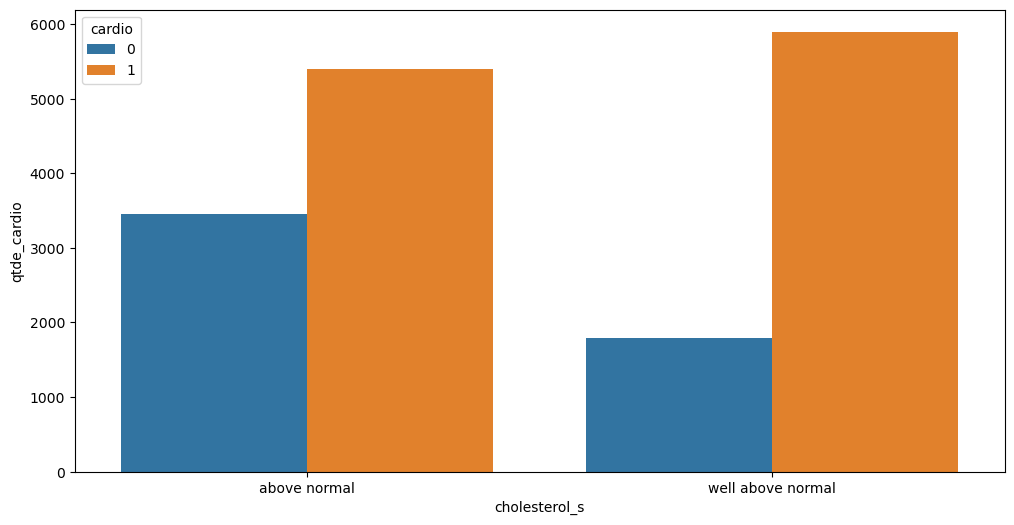

In [56]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'cholesterol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE

### - H5 - In proportion, individuals with alcohol 1 have more cardio disease than 0


In [57]:
aux1 = df4.groupby(['alcohol_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,alcohol_s,cardio,qtde_cardio
0,alcoolic,0,1798
1,alcoolic,1,1722
2,non alcoolic,0,30497
3,non alcoolic,1,31425


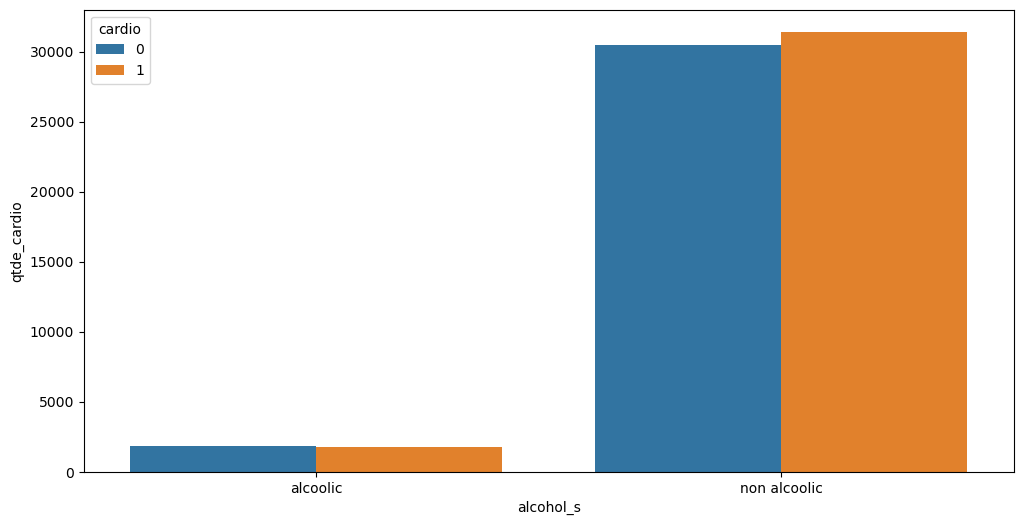

In [58]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'alcohol_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### FALSE - there's no difference

### - H6 - In proportion, individuals with smoke 1 have more cardio disease than 0


In [59]:
aux1 = df4.groupby(['smoke_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,smoke_s,cardio,qtde_cardio
0,non-smoking,0,29283
1,non-smoking,1,30371
2,smoking,0,3012
3,smoking,1,2776


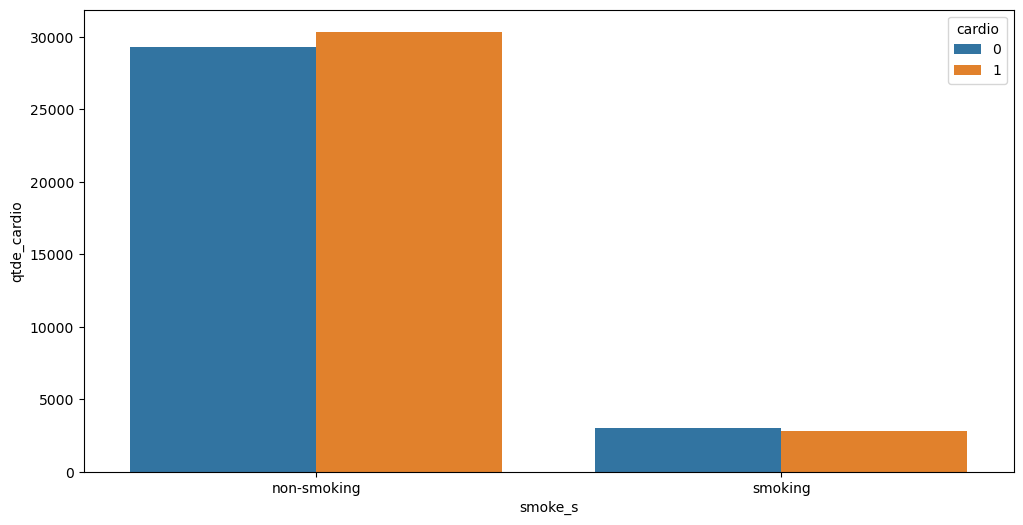

In [60]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'smoke_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### FALSE : no difference

### - H7 - In proportion, individuals with active 1 have less cardio disease than 0


In [61]:
aux1 = df4.groupby(['active_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,active_s,cardio,qtde_cardio
0,active,0,26420
1,active,1,26144
2,non active,0,5875
3,non active,1,7003


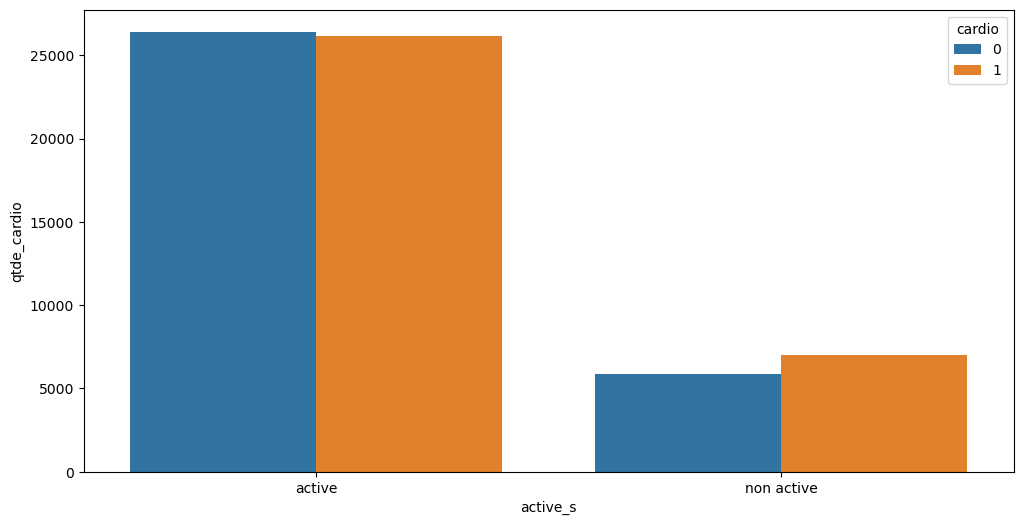

In [62]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'active_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE : non active has more chances

### - H8 - In proportion, individuals with glucose 2 have more cardio disease than 1


In [63]:
aux1 = df4.groupby(['gluc_s','cardio'], as_index = False).agg(qtde_cardio = ('cardio','count'))
aux1.head()

,gluc_s,cardio,qtde_cardio
0,above normal,0,1935
1,above normal,1,2898
2,normal,0,28460
3,normal,1,27088
4,well above normal,0,1900


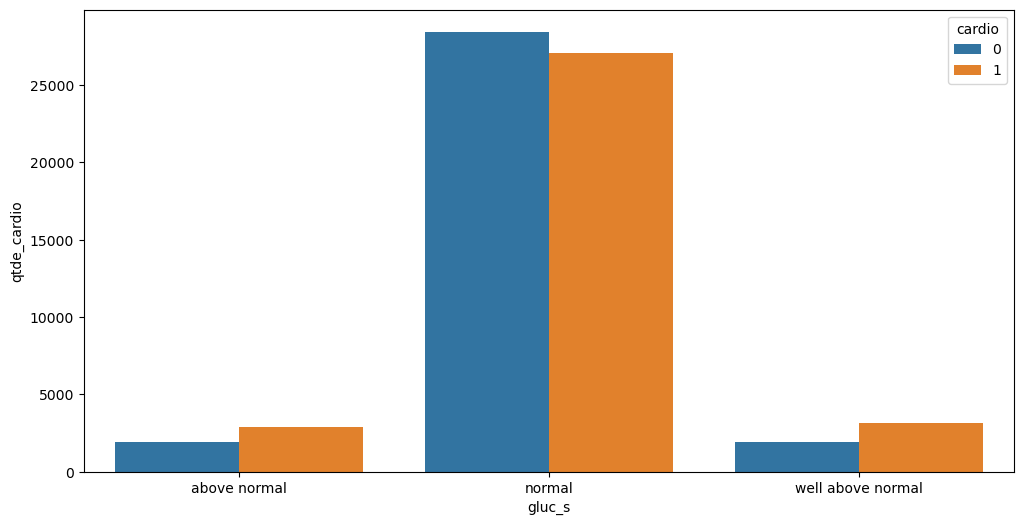

In [64]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
sns.barplot(data = aux1, x = 'gluc_s',y='qtde_cardio',hue = 'cardio', ax = axes);

### TRUE - increased levels of glucose can increase chances of cardio disease

### - H9 - In proportion, individuals with glucose 3 have more cardio disease than 2

## Multivariate analysis

C:\Users\pedro\AppData\Local\Temp\ipykernel_20280\1109461827.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df4.corr(method = 'pearson').round(3)
C:\Users\pedro\AppData\Local\Temp\ipykernel_20280\1109461827.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlation, dtype=np.bool))


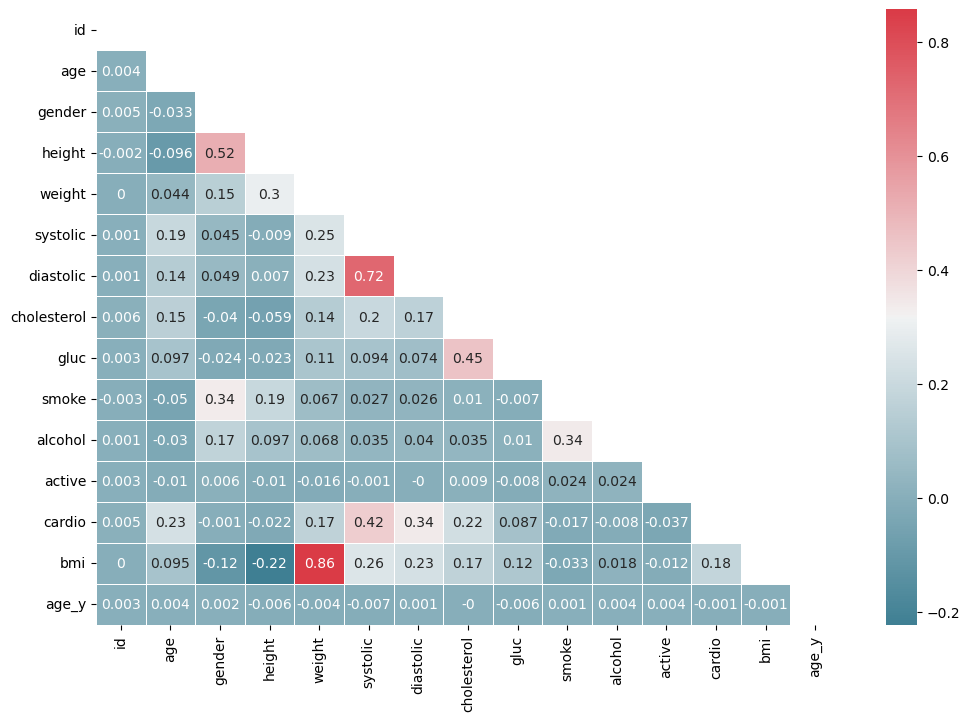

In [68]:
correlation = df4.corr(method = 'pearson').round(3)

fig, axes = plt.subplots(1,1,figsize=(12,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
sns.heatmap(correlation, cmap = cmap, mask=mask, linewidths=.5, annot=True, ax = axes);

# Data Preparation

In [82]:
df5 = df4.copy()
print(df5.shape)
df5.head(3)

(65442, 23)


,id,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,bmi,weight_s,blood_pressure_s,age_y,gender_s,cholesterol_s,gluc_s,smoke_s,alcohol_s,active_s
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967,normal,high stage one,50,male,normal,normal,non-smoking,non alcoolic,active
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.928,obese,high stage two,55,female,well above normal,normal,non-smoking,non alcoolic,active
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.508,normal,high stage one,51,female,well above normal,normal,non-smoking,non alcoolic,non active


In [83]:
cols_drop = ['age','id','gender_s','cholesterol_s','gluc_s','smoke_s','alcohol_s','active_s']

In [84]:
df5 = df5.drop(cols_drop, axis = 1)
df5.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,cardio,bmi,weight_s,blood_pressure_s,age_y
0,2,168,62.0,110,80,1,1,0,0,1,0,21.967,normal,high stage one,50
1,1,156,85.0,140,90,3,1,0,0,1,1,34.928,obese,high stage two,55
2,1,165,64.0,130,70,3,1,0,0,0,1,23.508,normal,high stage one,51


## Train/Test Split

In [99]:
X = df5.drop(['cardio'], axis = 1).copy()
y = df5[['cardio']].copy()

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [101]:
X_train.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,bmi,weight_s,blood_pressure_s,age_y
6289,1,153,53.0,120,80,1,1,0,0,1,22.641,normal,high stage one,48
64713,1,157,59.0,125,90,1,1,0,0,1,23.936,normal,high stage two,51
61780,1,160,66.0,150,100,3,3,0,0,1,25.781,normal,high stage two,54


## MinMax

In [102]:
cols_mms = ['height','weight','systolic','diastolic','age_y','bmi']

In [103]:
for i in cols_mms:
    min_max = MinMaxScaler()
    X_train[i] = min_max.fit_transform(X_train[[i]].values)
    joblib.dump(min_max, '../models/min_max_{}.pkl'.format(i))
    
    X_test[i] = min_max.transform(X_test[[i]].values)

In [104]:
X_train.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,bmi,weight_s,blood_pressure_s,age_y
6289,1,0.483,0.081,0.234,0.189,1,1,0,0,1,0.076,normal,high stage one,0.543
64713,1,0.529,0.119,0.280,0.324,1,1,0,0,1,0.087,normal,high stage two,0.629
61780,1,0.563,0.163,0.514,0.459,3,3,0,0,1,0.103,normal,high stage two,0.714


In [105]:
X_test.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,bmi,weight_s,blood_pressure_s,age_y
33140,1,0.379,0.062,0.327,0.189,1,1,0,0,1,0.089,normal,high stage one,0.457
59548,1,0.598,0.294,0.421,0.324,3,3,0,0,0,0.161,obese,high stage two,0.886
34237,2,0.598,0.094,0.234,0.189,3,1,1,0,1,0.060,normal,high stage one,0.714


## One Hot Encoding

In [106]:
cols_oh = ['weight_s','blood_pressure_s']

X_train = pd.get_dummies(X_train, columns = cols_oh, prefix = ['dw','db'])
X_test = pd.get_dummies(X_test, columns = cols_oh, prefix = ['dw','db'])

In [107]:
X_train.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,bmi,age_y,dw_normal,dw_obese,dw_overweight,dw_underweight,db_elevated,db_high stage one,db_high stage two,db_hypertensive crisis,db_normal
6289,1,0.483,0.081,0.234,0.189,1,1,0,0,1,0.076,0.543,1,0,0,0,0,1,0,0,0
64713,1,0.529,0.119,0.280,0.324,1,1,0,0,1,0.087,0.629,1,0,0,0,0,0,1,0,0
61780,1,0.563,0.163,0.514,0.459,3,3,0,0,1,0.103,0.714,1,0,0,0,0,0,1,0,0


In [108]:
X_test.head(3)

,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alcohol,active,bmi,age_y,dw_normal,dw_obese,dw_overweight,dw_underweight,db_elevated,db_high stage one,db_high stage two,db_hypertensive crisis,db_normal
33140,1,0.379,0.062,0.327,0.189,1,1,0,0,1,0.089,0.457,1,0,0,0,0,1,0,0,0
59548,1,0.598,0.294,0.421,0.324,3,3,0,0,0,0.161,0.886,0,1,0,0,0,0,1,0,0
34237,2,0.598,0.094,0.234,0.189,3,1,1,0,1,0.060,0.714,1,0,0,0,0,1,0,0,0


In [109]:
X_train.to_parquet('../data/processed/X_train.parquet',index = False)
X_test.to_parquet('../data/processed/X_test.parquet',index = False)
y_train.to_parquet('../data/processed/y_train.parquet',index = False)
y_test.to_parquet('../data/processed/y_test.parquet',index = False)

# Feature Selection

In [110]:
try:
    X_train = pd.read_parquet('../data/processed/X_train.parquet')
    X_test = pd.read_parquet('../data/processed/X_test.parquet')
    y_train = pd.read_parquet('../data/processed/y_train.parquet')
    y_test = pd.read_parquet('../data/processed/y_test.parquet')
except Exception as e:
    print(e)

## Boruta

## Model

In [180]:
THRESHOLD = 0.5

### LGBM

In [191]:
lgbm = LGBMClassifier(random_state=42, n_jobs=2)
# # fit
# rf.fit(x_train, y_train)

# # prediction
# y_hat_val = rf.predict(x_val)

# # performance
# rf_metrics = ml_metrics( 'random_forest', y_val, y_hat_val)
lgbm_metrics = model_cross_validation('lgbm', lgbm, X_train, y_train, THRESHOLD)

### SGD

In [136]:
# model
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=2)
# # fit
# rf.fit(x_train, y_train)

# # prediction
# y_hat_val = rf.predict(x_val)

# # performance
# rf_metrics = ml_metrics( 'random_forest', y_val, y_hat_val)
sgd_metrics = model_cross_validation('sgd', sgd, X_train, y_train, THRESHOLD)

### RF

In [131]:
# model
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=10, max_depth=10,n_jobs = 2, random_state = 42)

# # fit
# rf.fit(x_train, y_train)

# # prediction
# y_hat_val = rf.predict(x_val)

# # performance
# rf_metrics = ml_metrics( 'random_forest', y_val, y_hat_val)
rf_metrics = model_cross_validation('random_forest', rf, X_train, y_train, THRESHOLD)

### LR

In [132]:
# model
lr_model = LogisticRegression(n_jobs = 2, random_state = 42)

# # fit
# lr_model.fit(x_train, y_train)

# # prediction
# y_hat_val = lr_model.predict(x_val)

# # performance
# lr_metrics = ml_metrics( 'logistic_regression', y_val, y_hat_val)
lr_metrics = model_cross_validation('logistic_regression', lr_model, X_train, y_train, THRESHOLD)

### XGB

In [133]:
# model
xgb_model = XGBClassifier(n_estimators=100, max_depth=10,n_jobs = 2, random_state = 42)

# # fit
# xgb_model.fit(x_train, y_train)

# # prediction
# y_hat_val = xgb_model.predict(x_val)

# # performance
# xgb_metrics = ml_metrics( 'xgb_classifier', y_val, y_hat_val)
xgb_metrics = model_cross_validation('xgb_classifier', xgb_model, X_train, y_train, THRESHOLD)

### KNN

In [134]:
# model
knn_model = KNeighborsClassifier(n_neighbors= 10,n_jobs = 2)

# # fit
# knn_model.fit(x_train, y_train)

# # prediction
# y_hat_val = knn_model.predict(x_val)

# # performance
# knn_metrics = ml_metrics( 'knn_classifier', y_val, y_hat_val)
knn_metrics = model_cross_validation('knn_classifier', knn_model, X_train, y_train, THRESHOLD)

### Comparison

In [137]:
modeling_result = pd.concat([lgbm_metrics, sgd_metrics,rf_metrics, xgb_metrics, lr_metrics, knn_metrics])
modeling_result.reset_index(drop = True, inplace = True)
modeling_result.style.highlight_max(color='darkorange')

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm,76.030000,66.690000,71.050000,72.470000,45.030000,77.720000
1,sgd,77.120000,63.350000,69.380000,71.810000,43.730000,77.350000
2,random_forest,75.800000,67.210000,71.240000,72.520000,45.110000,77.760000
3,xgb_classifier,73.530000,65.650000,69.360000,70.620000,41.320000,75.500000
4,logistic_regression,76.850000,64.030000,69.850000,72.010000,44.130000,77.540000
5,knn_classifier,74.520000,62.660000,68.070000,70.230000,40.580000,74.790000


### Confusion Matrix

In [155]:
cm_lgbm = confusion_matrix(y_test, lgbm.predict(X_test), normalize = 'pred')
cm_sgd = confusion_matrix(y_test, sgd.predict(X_test), normalize = 'pred')
cm_rf = confusion_matrix(y_test, rf.predict(X_test), normalize = 'pred')
cm_lr = confusion_matrix(y_test, lr_model.predict(X_test), normalize = 'pred')
cm_xgb = confusion_matrix(y_test, xgb_model.predict(X_test), normalize = 'pred')
cm_knn = confusion_matrix(y_test, knn_model.predict(X_test), normalize = 'pred')

In [156]:
cm_lgbm = 100*cm_lgbm.round(4)
cm_sgd = 100*cm_sgd.round(4)
cm_rf = 100*cm_rf.round(4)
cm_lr = 100*cm_lr.round(4)
cm_xgb = 100*cm_xgb.round(4)
cm_knn = 100*cm_knn.round(4)

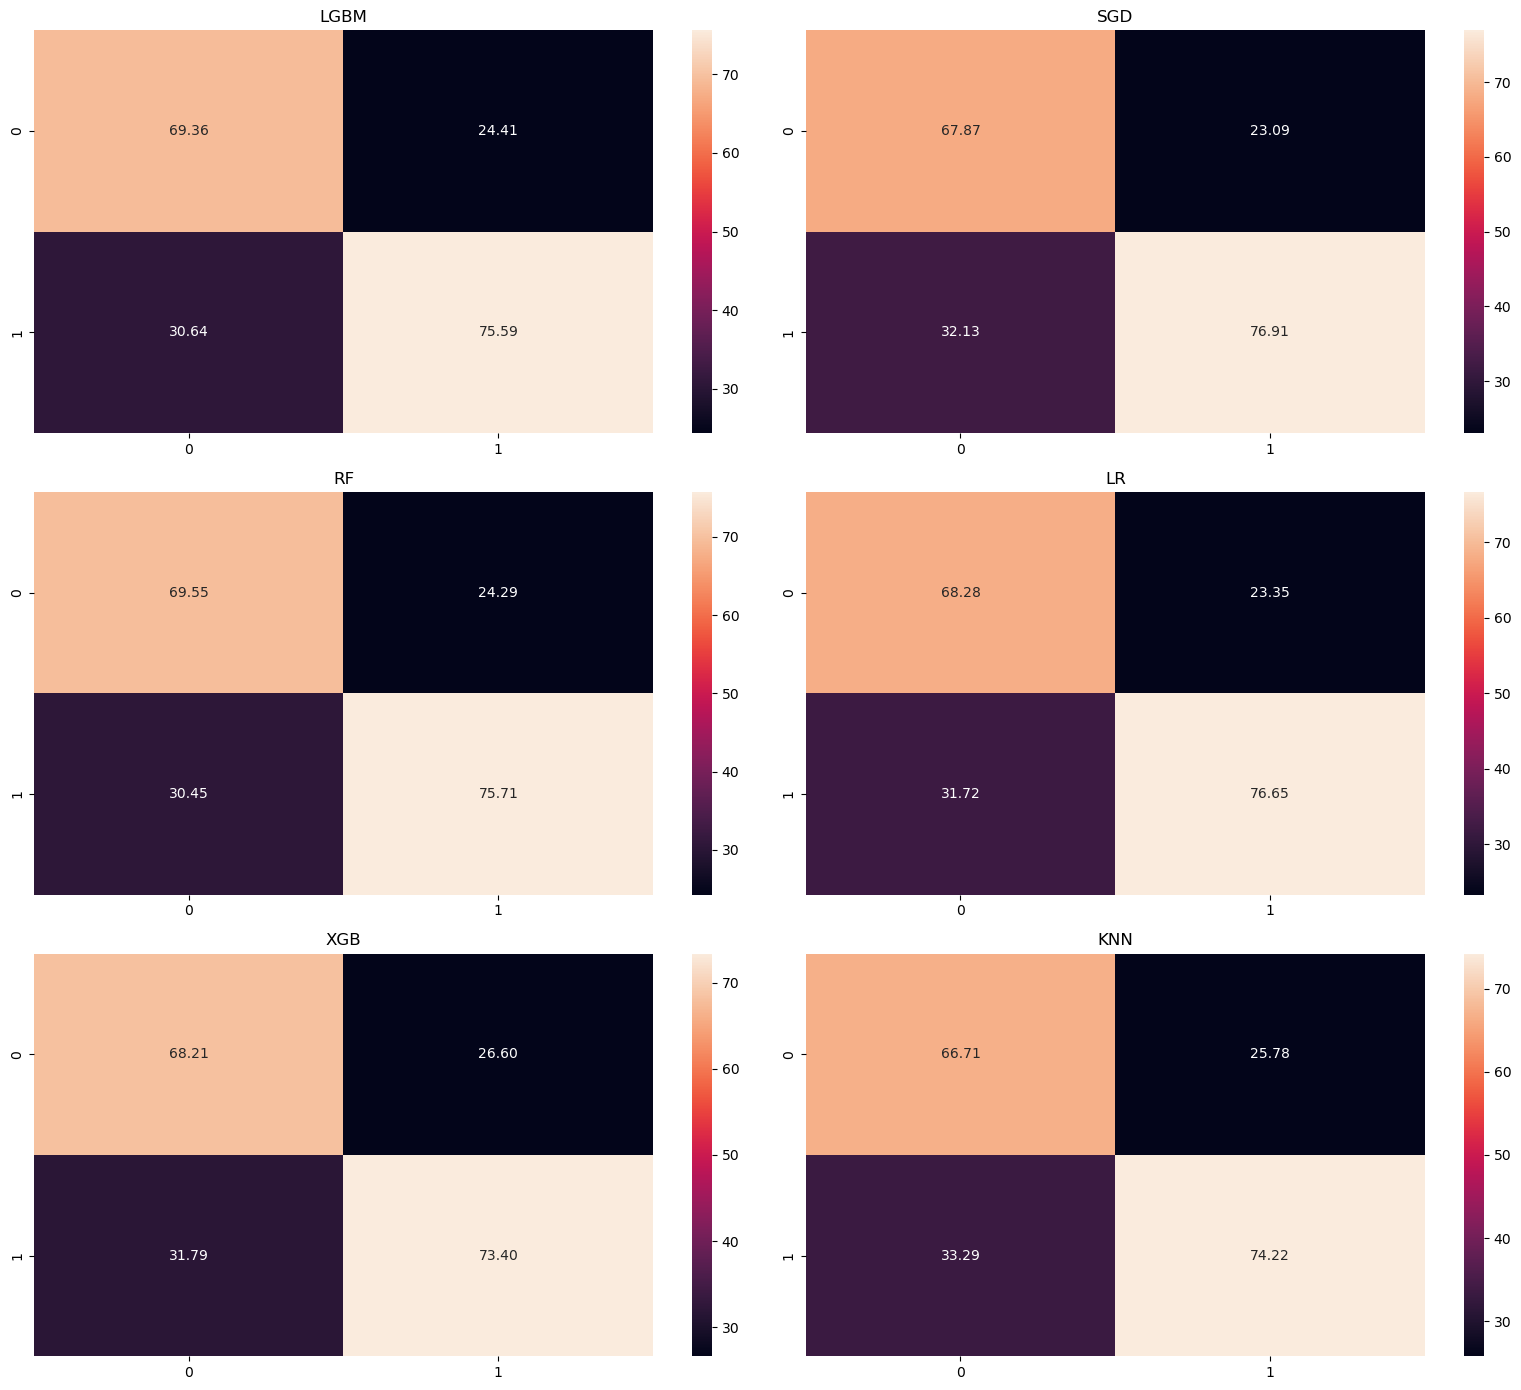

In [157]:
fig, axes = plt.subplots(3,2,figsize=(16,14))

sns.heatmap(cm_lgbm, annot=True, fmt = '.2f',ax = axes[0,0])
sns.heatmap(cm_sgd, annot=True, fmt = '.2f', ax = axes[0,1])
sns.heatmap(cm_rf, annot=True, fmt = '.2f', ax = axes[1,0])
sns.heatmap(cm_lr, annot=True, fmt = '.2f', ax = axes[1,1])
sns.heatmap(cm_xgb, annot=True, fmt = '.2f', ax = axes[2,0])
sns.heatmap(cm_knn, annot=True, fmt = '.2f', ax = axes[2,1])

axes[0,0].set_title('LGBM')
axes[0,1].set_title('SGD')
axes[1,0].set_title('RF')
axes[1,1].set_title('LR')
axes[2,0].set_title('XGB')
axes[2,1].set_title('KNN')

plt.tight_layout()

### Probability Distribution

In [159]:
# store the predicted probabilities for class 1
y_pred_rf_prob = rf.predict_proba(X_test)[:,1]
y_pred_xgb_prob = xgb_model.predict_proba(X_test)[:,1]
y_pred_lgbm_prob = lgbm.predict_proba(X_test)[:,1]

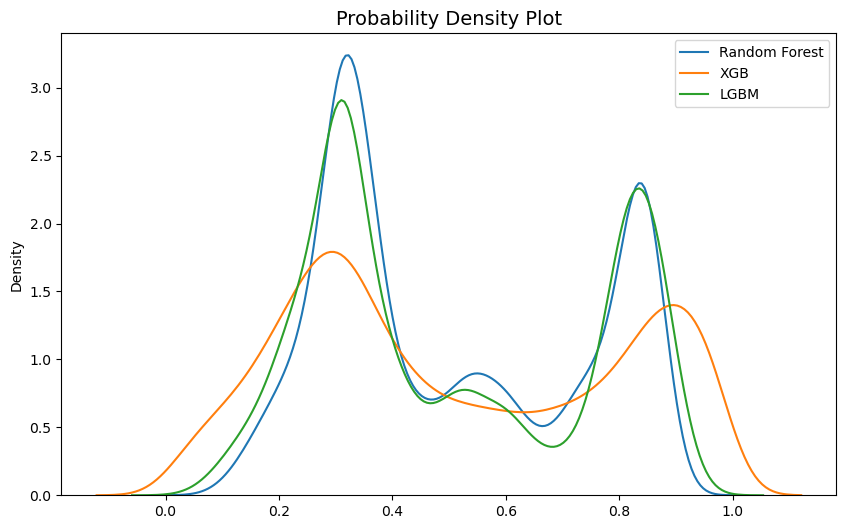

In [160]:
# sets the plot size
plt.figure(figsize=(10,6))

# plots
sns.kdeplot(y_pred_rf_prob, label='Random Forest')
sns.kdeplot(y_pred_xgb_prob, label='XGB')
sns.kdeplot(y_pred_lgbm_prob, label='LGBM')

# sets the plot features
plt.title("Probability Density Plot", fontsize=14)
plt.legend()

# display the plot
plt.show()

### Brier score

In [162]:
# calculates the Brier Score Loss
bsl_rf = brier_score_loss(y_test, y_pred_rf_prob, pos_label=1)
bsl_xgb = brier_score_loss(y_test, y_pred_xgb_prob, pos_label=1)
bsl_lgbm = brier_score_loss(y_test, y_pred_lgbm_prob, pos_label=1)

# prints the calculated Brier Score Loss for each algorithm probability
print(f'Brier Score Loss (Random Forest): {bsl_rf}')
print(f'Brier Score Loss (XGB): {bsl_xgb}')
print(f'Brier Score Loss (LGBM): {bsl_lgbm}')

Brier Score Loss (Random Forest): 0.1900100348936879
Brier Score Loss (XGB): 0.20333894554238907
Brier Score Loss (LGBM): 0.1892393539297594


##### Model chosen: **LGBM**

### Cross-Validation all dataset

In [163]:
X_full = pd.concat([X_train, X_test], axis = 0)
y_full = pd.concat([y_train, y_test], axis = 0)

In [164]:
lgbm = LGBMClassifier(random_state=42, n_jobs=2)
# # fit
# rf.fit(x_train, y_train)

# # prediction
# y_hat_val = rf.predict(x_val)

# # performance
# rf_metrics = ml_metrics( 'random_forest', y_val, y_hat_val)
lgbm_metrics = model_cross_validation('lgbm', lgbm, X_full, y_full, THRESHOLD)

In [165]:
lgbm_metrics

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm,76.28,66.25,70.91,72.47,45.02,77.82


# Hyperparameter fine-tunning

In [166]:
param = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

MAX_EVAL = 5

In [167]:
lgbm_inst = LGBMClassifier(random_state=42, n_jobs=2)

In [169]:
# preapres RandomizedSearchCV object
lgbm_cv = RandomizedSearchCV(estimator=lgbm_inst, param_distributions=param,
                                scoring='f1', n_iter=100, cv=MAX_EVAL, verbose=2,
                                random_state=42, n_jobs=2)

In [171]:
# fits the RandomizedSearchCV object
lgbm_cv.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=2, random_state=42),
                   n_iter=100, n_jobs=2,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_dep...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256], dtype=int32),
                                        'subsample': array([0.25      , 0.30357143, 0.35714286, 0.41071429, 0.46428571,
       0.51785714, 0.57142857, 0.625     , 0.67857143, 0.73214286,
       0.78571429, 0.83928571, 0.89285714, 0.94642857, 1.        ])},
                   random_state=42, scoring='f1', verbose=2)

In [172]:
# best estimator
lgbm_cv.best_estimator_

LGBMClassifier(colsample_bytree=0.775, learning_rate=0.001, max_depth=8,
               min_data_in_leaf=800, n_estimators=85, n_jobs=2, num_leaves=256,
               random_state=42, subsample=0.25)

In [184]:
# extract the best estimator
lgbm_tuned = lgbm_cv.best_estimator_

In [181]:
lgbm_tuned_metrics = model_cross_validation('lgbm tuned',lgbm_tuned, X_full, y_full, THRESHOLD)

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGB

In [182]:
lgbm_tuned_metrics

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm tuned,72.12,71.99,72.05,71.71,43.42,77.72


In [189]:
# Print the tuned parameters and score
print("\nTuned Parameters: {}".format(lgbm_tuned.get_params)) 
print("\nBest score: {}".format(lgbm_tuned.best_score_))


Tuned Parameters: <bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.775, learning_rate=0.001, max_depth=8,
               min_data_in_leaf=800, n_estimators=85, n_jobs=2, num_leaves=256,
               random_state=42, subsample=0.25)>

Best score: defaultdict(<class 'collections.OrderedDict'>, {})


## Final model

### ROC Curve

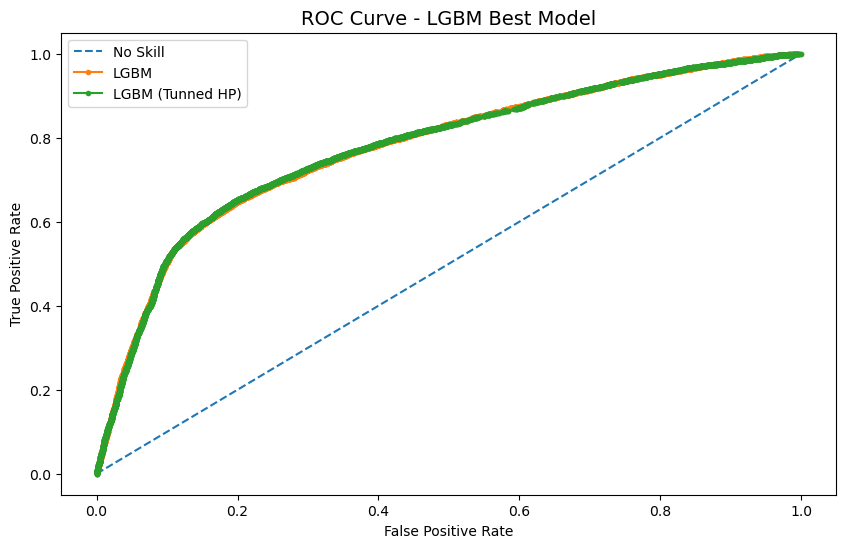

In [192]:
# sets the plot size
plt.figure(figsize=(10,6))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lgbm_tuned_model_probs = lgbm_tuned.predict_proba(X_test)
lgbm_probs = lgbm.predict_proba(X_test)


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tuned_fpr, tuned_tpr, _ = roc_curve(y_test, lgbm_tuned_model_probs[:,1])
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs[:,1])


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(tuned_fpr, tuned_tpr, marker='.', label='LGBM (Tunned HP)')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC Curve - LGBM Best Model', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

In [193]:
# extract the best estimator
lgbm_tuned = lgbm_cv.best_estimator_

# Profit Estimation

In [194]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [196]:
# calculates the cross validation scores

cv_scores = cross_val_score(lgbm_tuned, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=2)

price_per_percent = 500/5
baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [197]:
print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $164,697,433.28
Worst: $144,992,207.97


### Saving Model

In [198]:
joblib.dump(lgbm_tuned, '../models/lgbm_tuned.pkl')

['../models/lgbm_tuned.pkl']

# Calibrated Model

In [199]:
# trains the tunned model
lgbm_tuned.fit(X_train, y_train)

# defines and fits calibration model
lgbm_calibrated = CalibratedClassifierCV(lgbm_tuned, method='isotonic', cv=cv)
lgbm_calibrated.fit(X_train, np.ravel(y_train))

C:\Users\pedro\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\pedro\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGB

CalibratedClassifierCV(base_estimator=LGBMClassifier(colsample_bytree=0.775,
                                                     learning_rate=0.001,
                                                     max_depth=8,
                                                     min_data_in_leaf=800,
                                                     n_estimators=85, n_jobs=2,
                                                     num_leaves=256,
                                                     random_state=42,
                                                     subsample=0.25),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='isotonic')

C:\Users\pedro\miniconda3\lib\site-packages\sklearn\calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


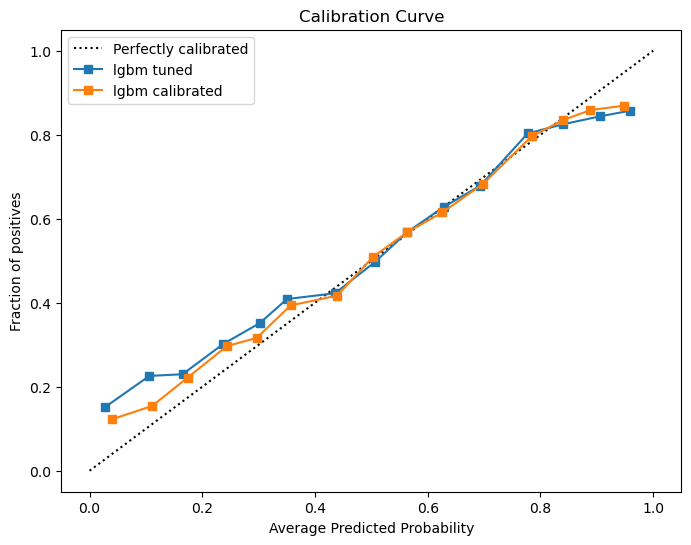

In [202]:
# defines number of bins
BINS = 15

# predicts probabilities
probs_lgbm_tuned = lgbm_tuned.predict_proba(X_test)
probs_lgbm_calibrated = lgbm_calibrated.predict_proba(X_test)


# calculates the calibration curve
frac_of_pos, mean_pred_val = calibration_curve(y_test, probs_lgbm_tuned[:, 1], 
                                               n_bins=BINS, normalize=True)
calib_frac_of_pos, calib_mean_pred_val = calibration_curve(y_test, probs_lgbm_calibrated[:, 1],
                                                           n_bins=BINS, normalize=True)

# sets plot size
plt.figure(figsize=(8, 6))

# plots y = x; perfect calibrated
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

# plots the curve
plt.plot(mean_pred_val, frac_of_pos, 's-', label='lgbm tuned')
plt.plot(calib_mean_pred_val, calib_frac_of_pos, 's-', label='lgbm calibrated')


# sets plot features
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.title('Calibration Curve')
plt.legend();

In [207]:
lgbm_calibrated_metrics = model_cross_validation('lgbm calibrated',lgbm_calibrated, X_full, y_full, THRESHOLD)

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGB

In [208]:
lgbm_calibrated_metrics

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm calibrated,76.56,65.78,70.76,72.46,45.02,77.74


# Business Metrics

In [209]:
final_model_metrics = pd.concat([lgbm_calibrated_metrics, lgbm_tuned_metrics,lgbm_metrics])
final_model_metrics

,Model Name,Precision,Recall,F1-Score,Accuracy,Kappa,AUC
0,lgbm calibrated,76.56,65.78,70.76,72.46,45.02,77.74
0,lgbm tuned,72.12,71.99,72.05,71.71,43.42,77.72
0,lgbm,76.03,66.69,71.05,72.47,45.03,77.72


#### Considering these values:

In [210]:
price_per_percent = 500/5
baseline = 50
num_pacients = 70000

In [211]:
# calculates the cross validation scores

cv_scores = cross_val_score(lgbm_tuned, X_full, np.ravel(y_full), cv = cv, scoring='precision', n_jobs=2)

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2

accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

In [212]:
baseline_today_lower = 55
baseline_today_upper = 65

amount_best_baseline = (65 - baseline) * price_per_percent * num_pacients
amount_worst_baseline = (55 - baseline) * price_per_percent * num_pacients

In [222]:
bus_dict = {'Model':['LGBM TUNED', 'BASELINE','Profit'],
           'Best Scenario': [amount_best,amount_best_baseline,amount_best-amount_best_baseline],
           'Worst Scenario': [amount_worst,amount_worst_baseline,amount_worst-amount_best_baseline]}

df_business = pd.DataFrame(bus_dict)

df_business['Worst Scenario'] = df_business['Worst Scenario'].map('${:,.2f}'.format)
df_business['Best Scenario'] = df_business['Best Scenario'].map('${:,.2f}'.format)
df_business

,Model,Best Scenario,Worst Scenario
0,LGBM TUNED,"$164,697,433.28","$144,992,207.97"
1,BASELINE,"$105,000,000.00","$35,000,000.00"
2,Profit,"$59,697,433.28","$39,992,207.97"
